In [1]:
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import defaultdict
import os
import re
import itertools
import networkx as nx
import matplotlib.pyplot as plt
from nltk import ne_chunk, pos_tag
from nltk.tree import Tree

In [2]:
# For the movies, we can keep only the names that talk in the scenario and cretae links between adjacent names. (scene by scene, so that we do not connect characters in different scenes)

# Further idea, get the images of characters from fandom and create a smaller network with the most important ones based on some centrality.

---------------------------------------------------------------------------------------------------------------------------

# Algorithms and functions to create the edges

In [3]:
def read_books_from_folder(folder_path):
    # List to hold the content of each book
    books_content = []

    # Loop through each file in the folder
    for filename in os.listdir(folder_path):
        # Construct the full file path
        file_path = os.path.join(folder_path, filename)

        # Check if it's a file and not a directory
        if os.path.isfile(file_path):
            # Read the file and append its content to the list
            with open(file_path, 'r', encoding='utf-8') as file:
                books_content.append(file.read())

    return books_content

In [4]:
# Read the clean books and add their text to a list
folder_path = 'Books_cleaned' 
books_list = read_books_from_folder(folder_path)

In [5]:
# Function to get continuous chunks of named entities
def get_named_entities(text):
#     tokenise the sentence and extract the named entities 
    chunked = ne_chunk(pos_tag(word_tokenize(text)))
    continuous_chunk = []
    current_chunk = []

    for i in chunked:
        if type(i) == Tree:
            current_chunk.append(" ".join([token for token, pos in i.leaves()]))
        elif current_chunk:
            named_entity = " ".join(current_chunk)
            if named_entity not in continuous_chunk:
                continuous_chunk.append(named_entity)
                current_chunk = []
        else:
            continue

    if current_chunk:
        named_entity = " ".join(current_chunk)
        if named_entity not in continuous_chunk:
            continuous_chunk.append(named_entity)

    return continuous_chunk

In [6]:
# Function to create a mapping from partial to full names
def create_name_mapping(character_df):
    name_mapping = {}  
    
    for i in range(len(character_df)):
        
        name = character_df.loc[i, "name"]
        
        if pd.isnull(character_df.loc[i, "first_name"]) and pd.isnull(character_df.loc[i, "last_name"]):
            name_mapping[name] = name
        elif pd.isnull(character_df.loc[i, "last_name"]) and not pd.isnull(character_df.loc[i, "first_name"]):
            if character_df.loc[i, "first_name"] not in name_mapping:
                name_mapping[character_df.loc[i, "first_name"]] = [name]
            else: 
                name_mapping[character_df.loc[i, "first_name"]].append(name)
        elif pd.isnull(character_df.loc[i, "first_name"]) and not pd.isnull(character_df.loc[i, "last_name"]):
            # there is no character with only last name but let's handle this here
            name_mapping[character_df.loc[i, "last_name"]] = name
        else:
            name_mapping[name] = name
            if character_df.loc[i, "first_name"] not in name_mapping:
                name_mapping[character_df.loc[i, "first_name"]] = [name]
            else: 
                name_mapping[character_df.loc[i, "first_name"]].append(name)
            if character_df.loc[i, "last_name"] not in name_mapping:
                name_mapping[character_df.loc[i, "last_name"]] = [name]
            else:
                name_mapping[character_df.loc[i, "last_name"]].append(name)

    return name_mapping

In [7]:
def check_entities(entities):
    prefixes = ('Professor ', 'Madam ', 'Aunt ', 'Uncle ', 'Miss ', 'Mr. ', 'Mrs. ')
    new_entities = []

    for entity in entities:
        if entity.startswith(prefixes):
            # Remove the prefix from the entity
            for prefix in prefixes:
                if entity.startswith(prefix):
                    entity = entity[len(prefix):]
                    break
        new_entities.append(entity)
        
    return new_entities    

In [8]:
def find_entities(book_text, character_df):
    # Create a mapping from partial names to full names
    name_mapping = create_name_mapping(character_df)

    # Tokenize the book text into sentences
    sentences = nltk.sent_tokenize(book_text)

    # Initialize a dictionary to track the most recent mention of each character
    recent_mentions = {}

    # Find entities in each sentence and map partial names to full names
    sent_entity_list = []
    for sent in sentences:
        entities_old = get_named_entities(sent)
        entities = check_entities(entities_old) 
        names = []
        for entity in entities:
            if entity in name_mapping:
                
                # if entity is a partial name
                if isinstance(name_mapping[entity], list):
                    # If the character has been mentioned before
                    if entity in recent_mentions:
                        recent_character = recent_mentions[entity]
                    else:
                        # If the entity hasn't been mentioned, return the first character in the list for that last name
                        recent_character = name_mapping[entity][0]
                        # If entity is a last name insert character in recent mentions
                        if entity in character_df['last_name'].tolist():
                            recent_mentions[entity] = recent_character
                        # If entity is a first name, find last name and add it to recent mentions
                        else:
                            last_name = characters_df.loc[characters_df['first_name'] == entity, 'last_name'].values[0]
                            if type(last_name) != float: recent_mentions[last_name] = recent_character
 
                    names.append(recent_character)
    
                # if entity is a fullname
                else:                    
                    # Update the recent mention for the character by their last name
                    last_name = characters_df.loc[characters_df['name'] == entity, 'last_name'].values[0]
                    recent_mentions[last_name] = name_mapping[entity]
                    
                    names.append(name_mapping[entity])

        sent_entity_list.append({'sentence': sent, 'ents_old': entities_old, 'ents': entities, 'entity': names})

    # Create a dataframe from the list of sentencies-entities
    sent_entity_df = pd.DataFrame(sent_entity_list)

    return sent_entity_df

In [9]:
def find_relationships(sent_entity_df):
    # Define a window size to look for relationships within
    window_size = 3 # int(sent_entity_df.index.to_series().diff().mean())
    # print(window_size)
    # Initialize a list to hold relationships
    relationships = []

    # Loop through the sentences to find relationships within the window size
    for i in range(0, len(sent_entity_df) - window_size):
        window = sent_entity_df.iloc[i:i + window_size]
        all_entities = list(set(itertools.chain.from_iterable(window['entity'])))
        window_sentences = " ".join(window['sentence'])  # Combine sentences in the window
        for a, b in itertools.combinations(all_entities, 2):
            relationships.append({'source': min(a, b), 'target': max(a, b), 'sentence': window_sentences})

    # Create a DataFrame from the relationships
    relationships_df = pd.DataFrame(relationships)

    # Remove duplicate relationships
    relationships_df = relationships_df.drop_duplicates(subset=['source', 'target']).reset_index(drop=True) # ???????
    
    return relationships_df

---------------------------------------------------------------------------------------------------------------------------

# Build the graphs

In [10]:
def build_network(relationships_df):
    # If you wish to visualize the graph, continue with this part
    # Create a networkx graph from the relationships DataFrame
    G = nx.Graph()

    # Add edges from relationships_df to the graph
    for index, row in relationships_df.iterrows():
        G.add_edge(row['source'], row['target'])
    
    # Print number of nodes and edges
    print(G)

    # Use a circular layout for the nodes
    d = dict(G.degree)
    # pos = nx.kamada_kawai_layout(G)

    # Draw the network
    plt.figure(figsize=(12, 12))
    # nx.draw_networkx(G, pos, with_labels=False)
    nx.draw_kamada_kawai(G, node_size=[v * 3 for v in d.values()],node_color = "Yellow", edge_color="grey", width=0.2, alpha=0.5)
    labels = nx.draw_networkx_labels(G, pos=nx.kamada_kawai_layout(G), font_size=7)
    # Display the plot
    plt.show()
    
    return G

In [11]:
def most_degree(G):
    # Calculate degree of each node
    degrees = dict(G.degree())

    # Sort nodes by degree in descending order
    sorted_degrees = sorted(degrees.items(), key=lambda item: item[1], reverse=True)

    # Print the first 20 nodes with the highest degree
    print("Top 20 nodes by degree: \n")
    for node, degree in sorted_degrees[:20]:
        print(f"{node}: {degree}")

In [12]:
# # Read the characters list that we scrapped from fandom
# characters_df = pd.read_csv('characters_fandom.csv')

In [13]:
# relationships_df1

In [14]:
# sent_entity_df1 = find_entities(books_list[0], characters_df)
# relationships_df1 = find_relationships(sent_entity_df1)
# G1 = build_network(relationships_df1)
# most_degree(G1)

In [15]:
# sent_entity_df2 = find_entities(books_list[1], characters_df)
# relationships_df2 = find_relationships(sent_entity_df2)
# G2 = build_network(relationships_df2)
# most_degree(G2)

In [16]:
# sent_entity_df3 = find_entities(books_list[2], characters_df)
# relationships_df3 = find_relationships(sent_entity_df3)
# G3 = build_network(relationships_df3)
# most_degree(G3)

In [17]:
# sent_entity_df4 = find_entities(books_list[3], characters_df)
# relationships_df4 = find_relationships(sent_entity_df4)
# G4 = build_network(relationships_df4)
# most_degree(G4)

In [18]:
# sent_entity_df5 = find_entities(books_list[4], characters_df)
# relationships_df5 = find_relationships(sent_entity_df5)
# G5 = build_network(relationships_df5)
# most_degree(G5)

In [19]:
# sent_entity_df6 = find_entities(books_list[5], characters_df)
# relationships_df6 = find_relationships(sent_entity_df6)
# G6 = build_network(relationships_df6)
# most_degree(G6)

In [20]:
# sent_entity_df7 = find_entities(books_list[6], characters_df)
# relationships_df7 = find_relationships(sent_entity_df7)
# G7 = build_network(relationships_df7)
# most_degree(G7)

Graph with 215 nodes and 2204 edges


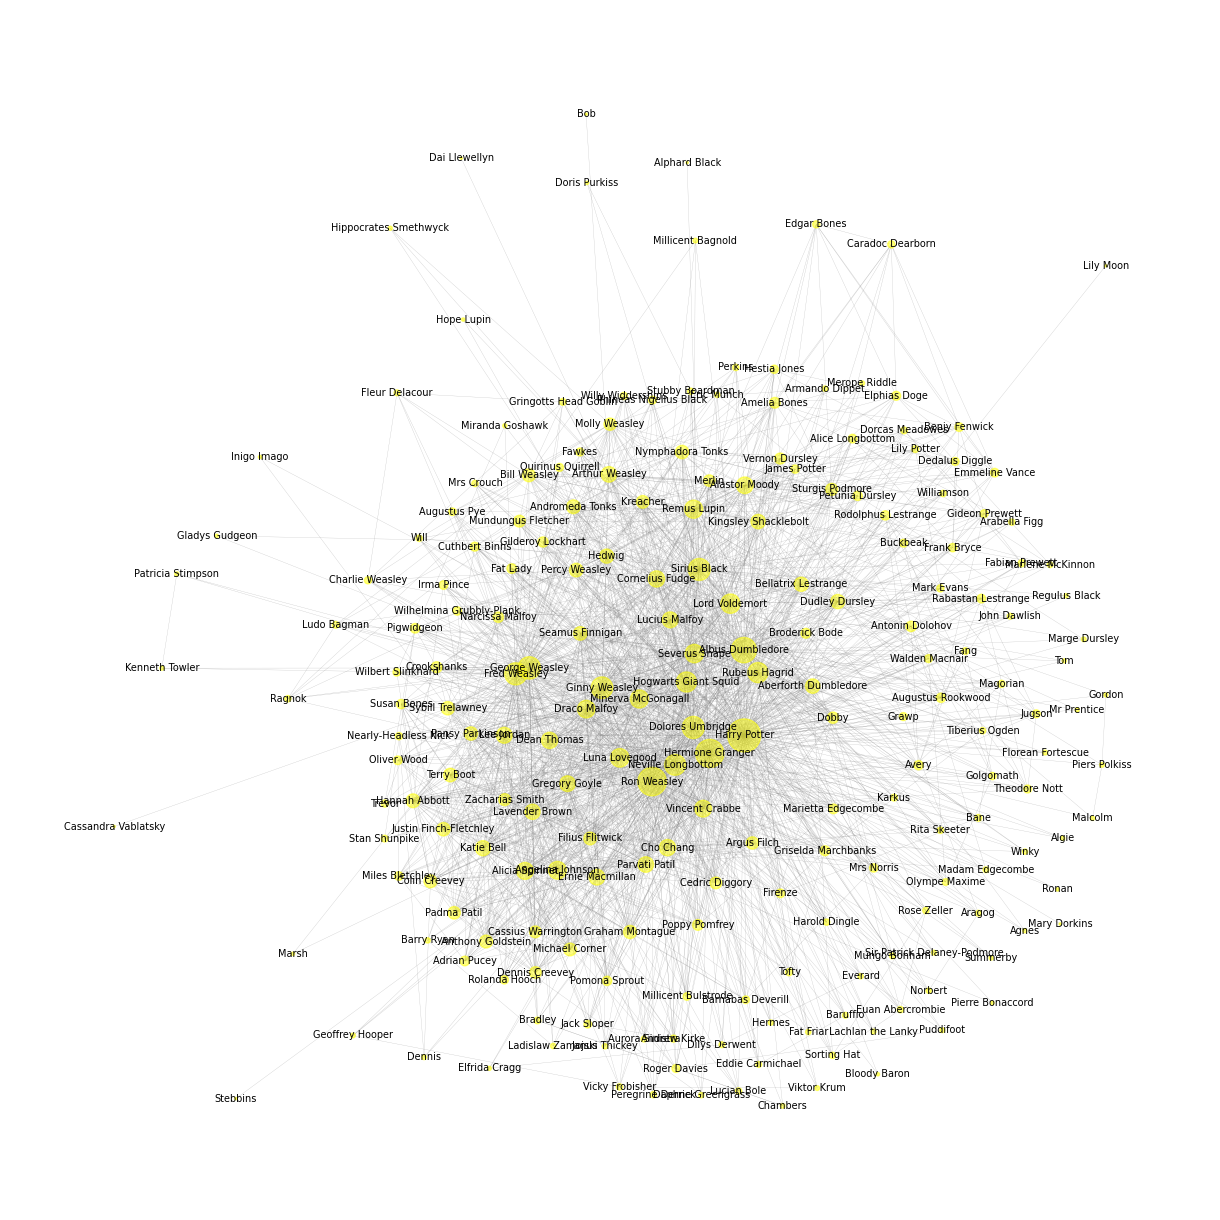

Top 20 nodes by degree: 

Harry Potter: 190
Ron Weasley: 141
Hermione Granger: 138
Albus Dumbledore: 111
George Weasley: 87
Fred Weasley: 85
Dolores Umbridge: 85
Sirius Black: 84
Ginny Weasley: 81
Neville Longbottom: 76
Hogwarts Giant Squid: 70
Rubeus Hagrid: 70
Lord Voldemort: 65
Luna Lovegood: 60
Severus Snape: 59
Remus Lupin: 57
Minerva McGonagall: 57
Angelina Johnson: 55
Draco Malfoy: 54
Alicia Spinnet: 50
Graph with 93 nodes and 748 edges


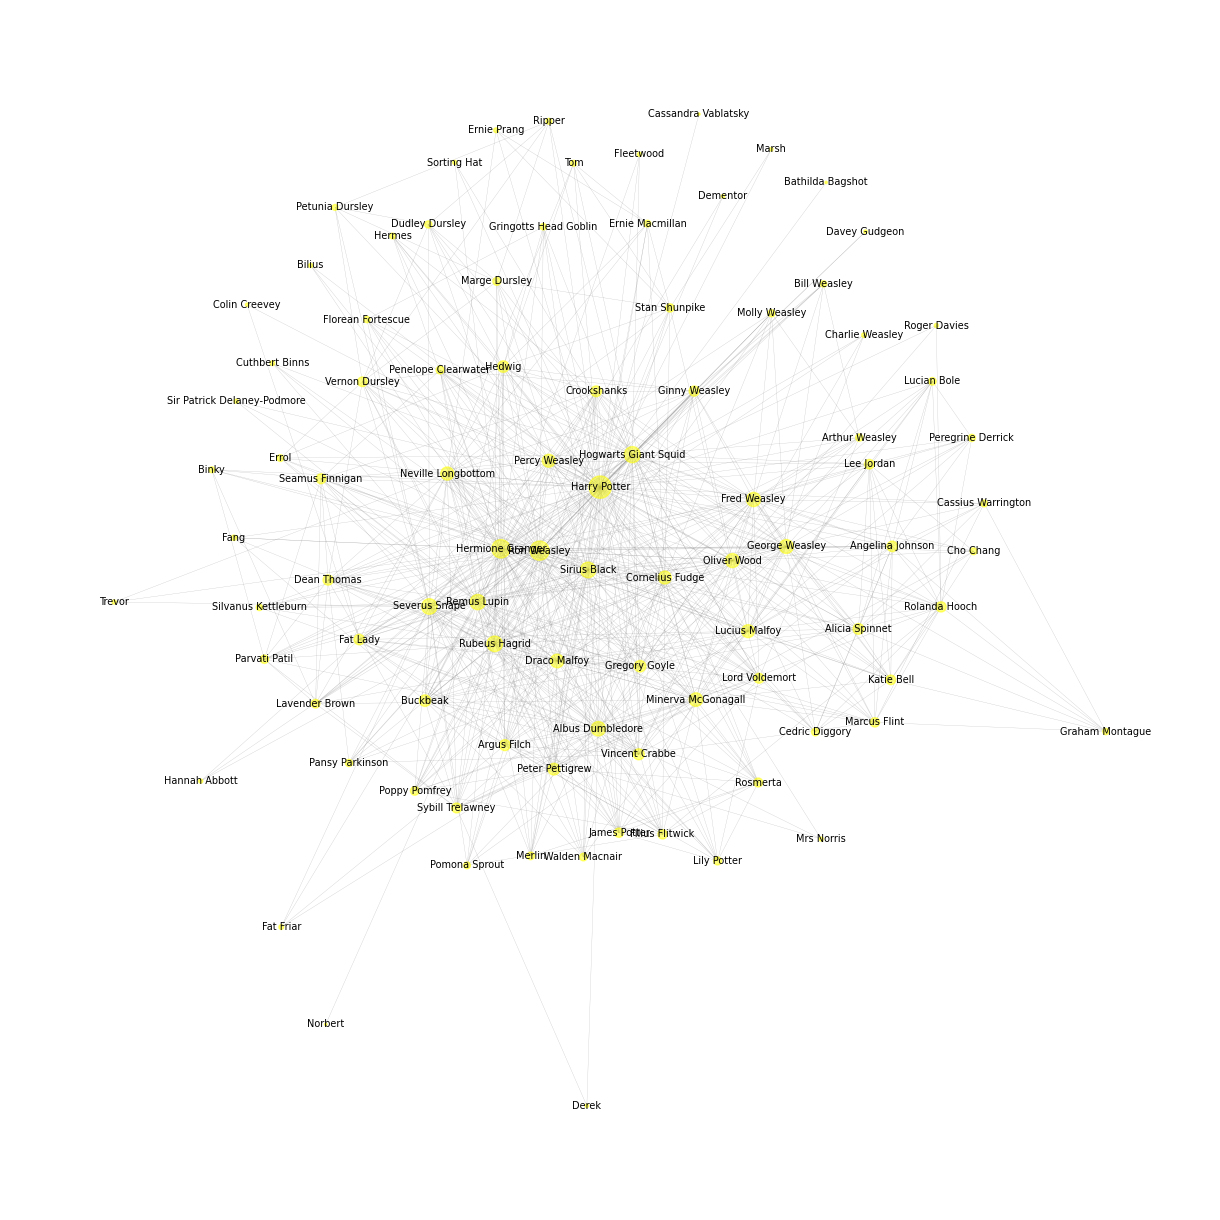

Top 20 nodes by degree: 

Harry Potter: 86
Ron Weasley: 64
Hermione Granger: 59
Hogwarts Giant Squid: 45
Severus Snape: 42
Rubeus Hagrid: 42
Sirius Black: 42
Remus Lupin: 40
Albus Dumbledore: 36
Fred Weasley: 35
George Weasley: 34
Oliver Wood: 34
Minerva McGonagall: 32
Draco Malfoy: 32
Neville Longbottom: 30
Percy Weasley: 29
Cornelius Fudge: 29
Lucius Malfoy: 29
Peter Pettigrew: 24
Hedwig: 23
Graph with 176 nodes and 1488 edges


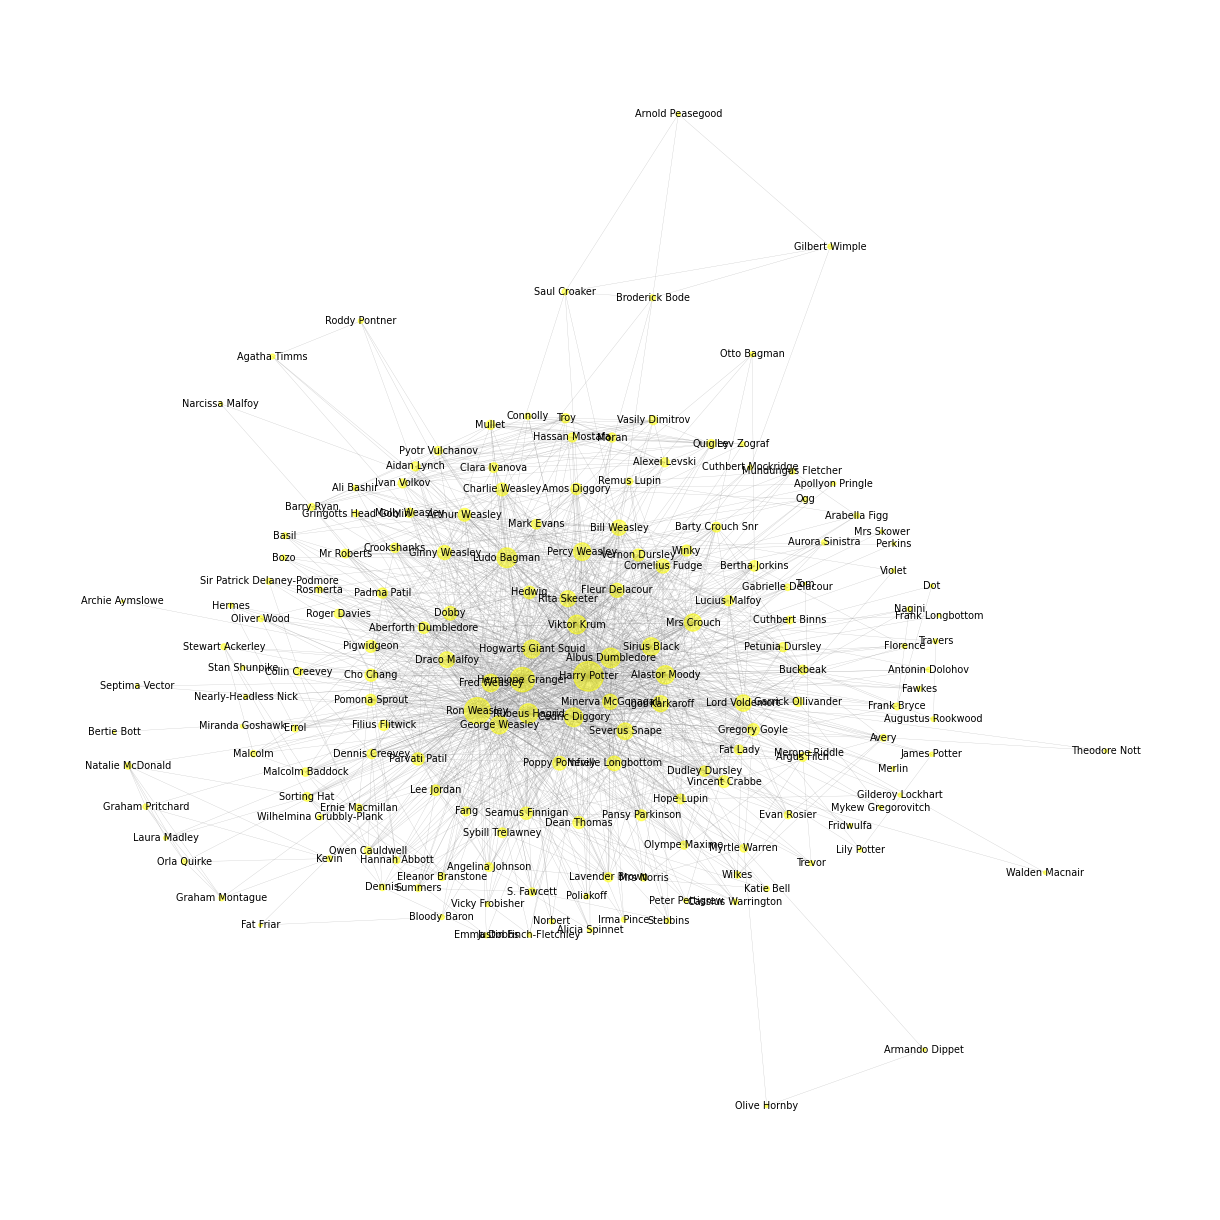

Top 20 nodes by degree: 

Harry Potter: 152
Ron Weasley: 119
Hermione Granger: 102
Ludo Bagman: 67
Albus Dumbledore: 66
Rubeus Hagrid: 65
Viktor Krum: 60
Cedric Diggory: 60
Alastor Moody: 58
Hogwarts Giant Squid: 55
George Weasley: 55
Sirius Black: 55
Percy Weasley: 53
Fred Weasley: 52
Mrs Crouch: 51
Severus Snape: 47
Lord Voldemort: 46
Igor Karkaroff: 44
Rita Skeeter: 43
Draco Malfoy: 42
Graph with 191 nodes and 1547 edges


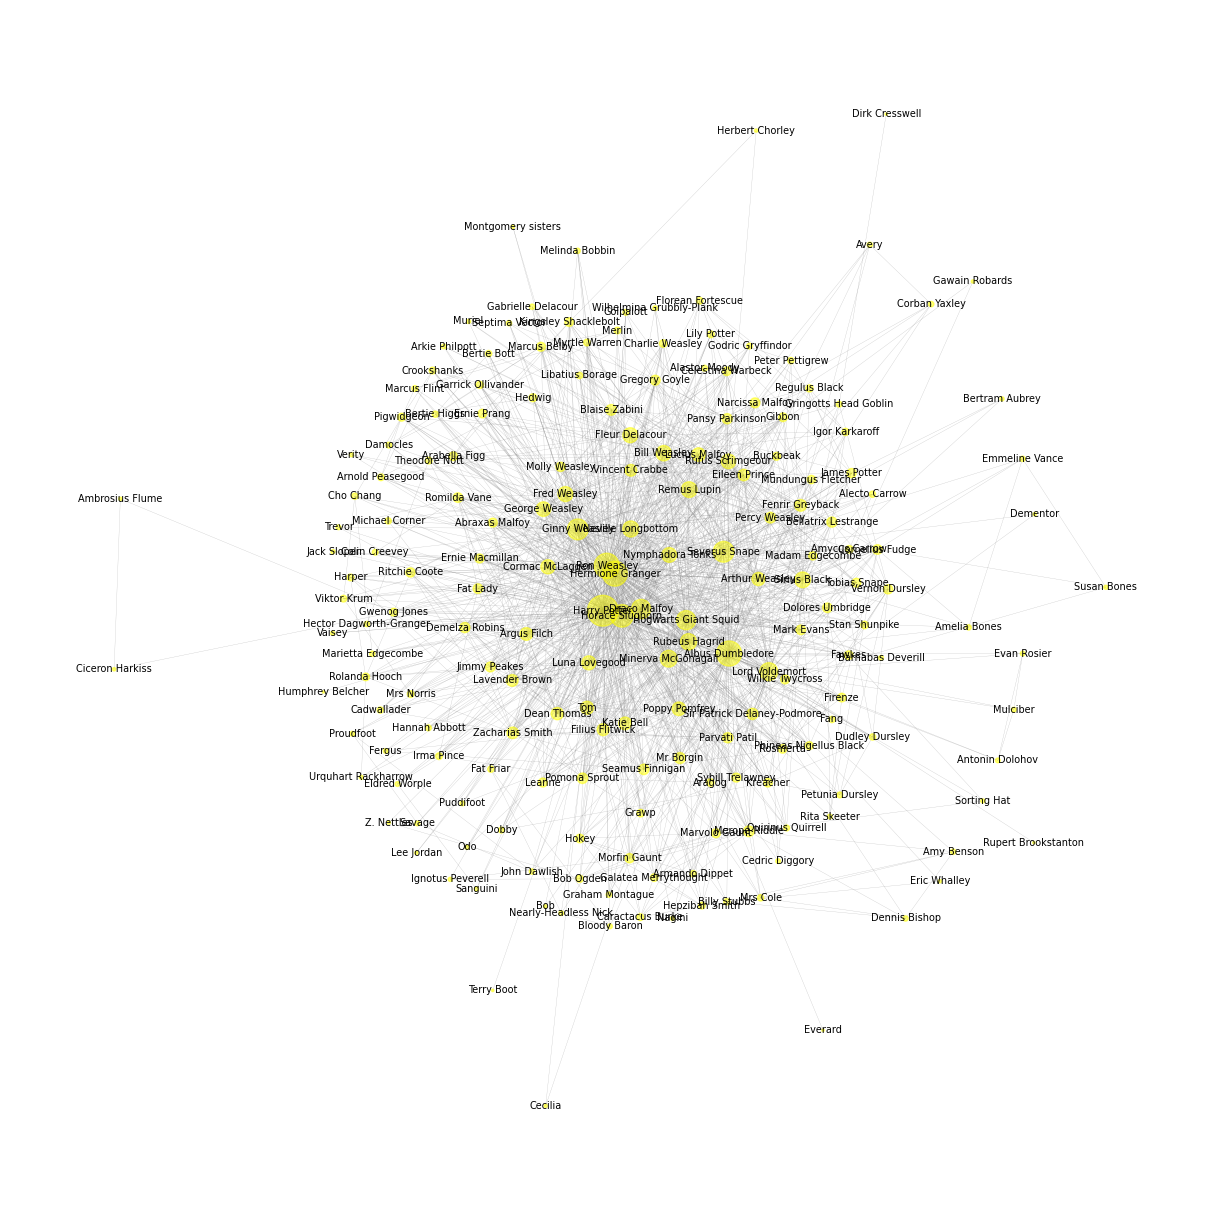

Top 20 nodes by degree: 

Harry Potter: 165
Albus Dumbledore: 109
Ron Weasley: 109
Hermione Granger: 107
Horace Slughorn: 88
Severus Snape: 75
Ginny Weasley: 75
Draco Malfoy: 65
Hogwarts Giant Squid: 64
Lord Voldemort: 56
Minerva McGonagall: 49
Rubeus Hagrid: 46
Neville Longbottom: 45
Sirius Black: 43
Remus Lupin: 43
Bill Weasley: 41
Fred Weasley: 39
Fleur Delacour: 39
Nymphadora Tonks: 38
Rufus Scrimgeour: 37
Graph with 91 nodes and 690 edges


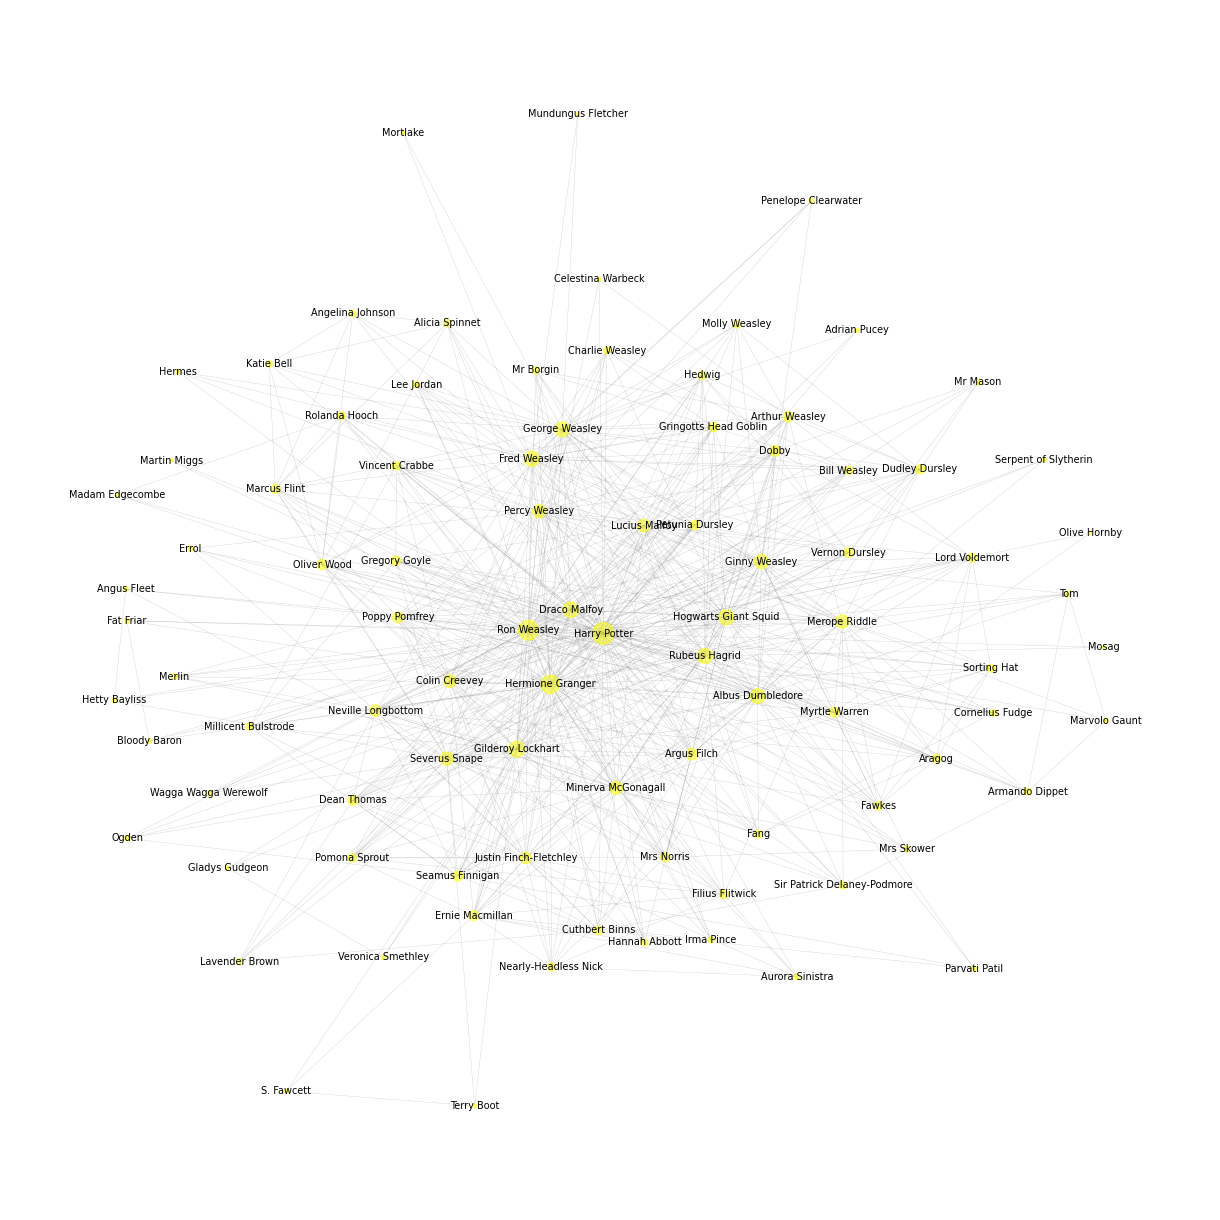

Top 20 nodes by degree: 

Harry Potter: 81
Ron Weasley: 68
Hermione Granger: 58
Gilderoy Lockhart: 43
Draco Malfoy: 41
Hogwarts Giant Squid: 39
Rubeus Hagrid: 39
Fred Weasley: 39
Albus Dumbledore: 37
George Weasley: 37
Ginny Weasley: 35
Severus Snape: 30
Percy Weasley: 30
Merope Riddle: 30
Minerva McGonagall: 29
Lucius Malfoy: 27
Colin Creevey: 27
Neville Longbottom: 23
Argus Filch: 23
Justin Finch-Fletchley: 22
Graph with 190 nodes and 1785 edges


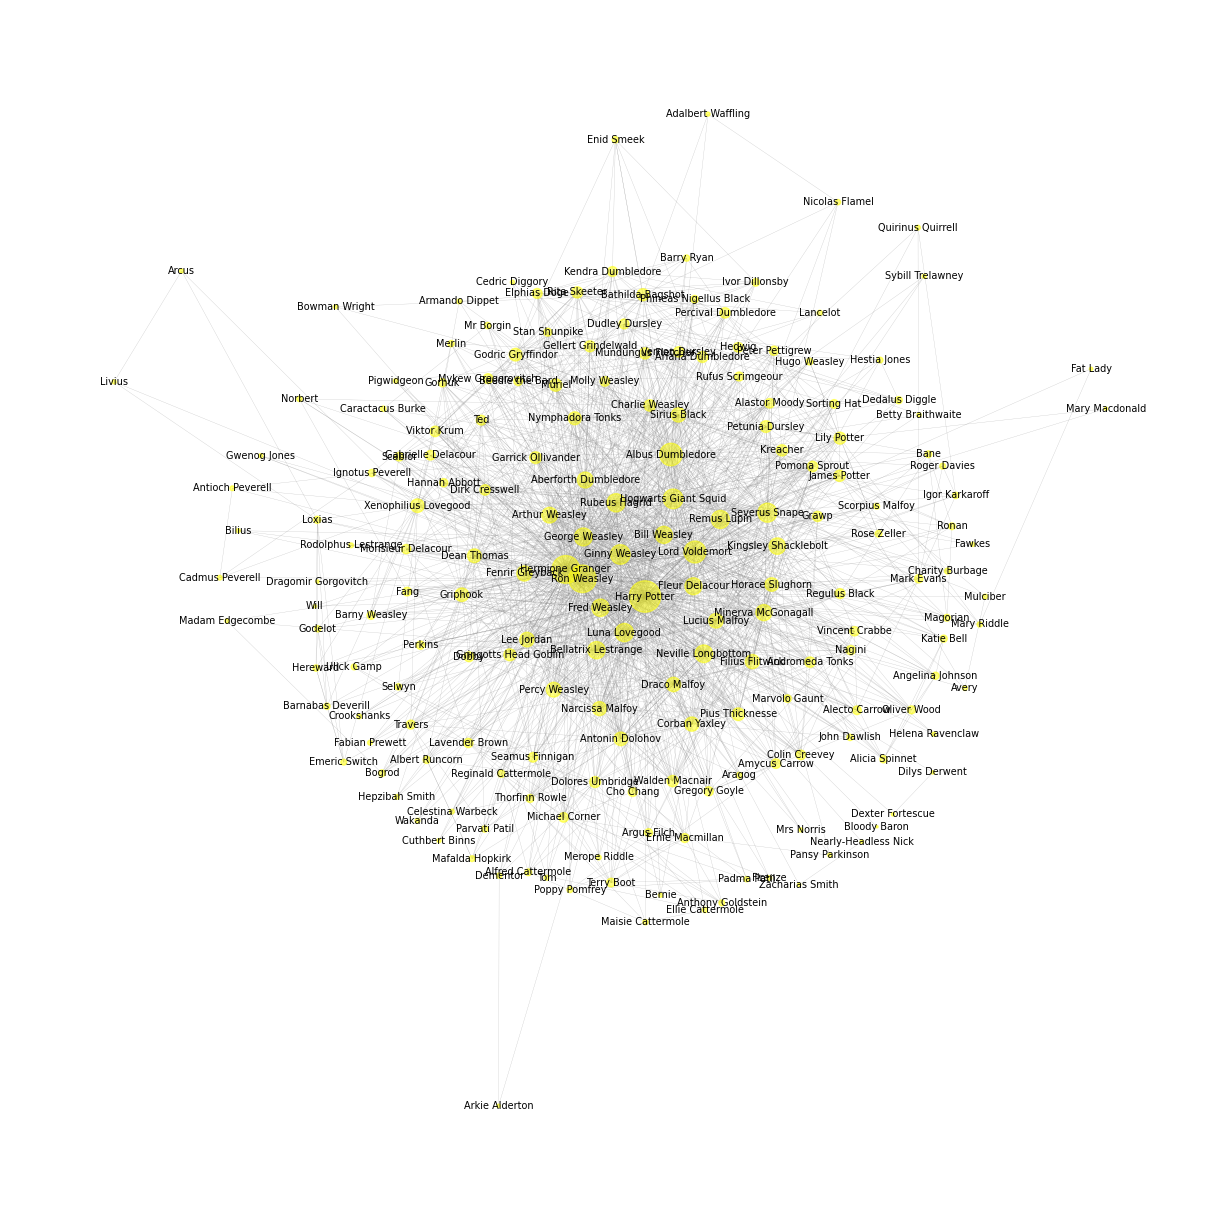

Top 20 nodes by degree: 

Harry Potter: 172
Hermione Granger: 134
Ron Weasley: 131
Albus Dumbledore: 88
Lord Voldemort: 83
Hogwarts Giant Squid: 67
Ginny Weasley: 67
Severus Snape: 63
Rubeus Hagrid: 58
Luna Lovegood: 58
Remus Lupin: 57
George Weasley: 56
Neville Longbottom: 54
Fred Weasley: 53
Bellatrix Lestrange: 52
Bill Weasley: 51
Fleur Delacour: 50
Kingsley Shacklebolt: 47
Minerva McGonagall: 45
Aberforth Dumbledore: 44


In [ ]:
characters_df = pd.read_csv('characters_fandom.csv')

# Create empty lists to store results
graphs = []
entities_dfs = []
relationships_dfs = []

for book in books_list:
    # Find entities for the current book
    sent_entity_df = find_entities(book, characters_df)
    entities_dfs.append(sent_entity_df)

    # Find relationships for the current book
    relationships_df = find_relationships(sent_entity_df)
    relationships_dfs.append(relationships_df)

    # Build a network for the current book
    G = build_network(relationships_df)
    graphs.append(G)

    # Calculate and print the most degree for the current book's graph
    most_degree(G)

# Now you can access the results for each book using the lists
for i, book in enumerate(books_list):
    print(f"Results for Book {i+1}:")
    print("Entities DataFrame:")
    print(entities_dfs[i])
    print("Relationships DataFrame:")
    print(relationships_dfs[i])
    print("Graph:")
    print(graphs[i])

---------------------------------------------------------------------------------------------------------------------------

# Size of networks

In [ ]:
# Create an empty DataFrame
networks_info_df = pd.DataFrame(columns=["nodes", "edges"])

# List of the 7 graphs G1 to G7
graphs = [G1, G2, G3, G4, G5, G6, G7]

# Iterate through the graphs
for i, graph in enumerate(graphs):
    # Extract the nodes and edges from the graph
    nodes = list(graph.nodes())
    edges = list(graph.edges())
    
    # Add the nodes and edges to networks_info_df
    networks_info_df.loc[i] = [ nodes, edges]

print(df)